In [12]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units

from datetime import datetime

In [43]:
# date, time and station of sounding to be plotted
year = 2024
month = 4
day = 16
hour = 12

station = "KCRP"

In [44]:
#get data from Iowa Environmental Mesonet (IEM) RAOB archive

#convert date and time to datetime object
dt = datetime(year=year,month=month,day=day,hour=hour)

#convert datetime object to string to add into the IEM url
t = dt.strftime('%Y%m%d%H%M')

#define the url
url = f"https://mesonet.agron.iastate.edu/json/raob.py?ts={t}&station={station}"
print(url)
#read the json sounding data using pandas
json = pd.read_json(url)

#convert the json sounding to a pandas dataframe
df = pd.json_normalize(json.profiles[0],'profile',['station','valid'])

#convert the "valid" variable to a datetime object
df['valid'] = pd.to_datetime(df['valid'])
print(df)

https://mesonet.agron.iastate.edu/json/raob.py?ts=202404161200&station=KCRP
       pres     hght  tmpc  dwpc   drct  sknt station  \
0    1006.0     14.0  24.6  22.8  155.0  10.0    KCRP   
1    1000.0     66.0  23.6  21.4  145.0  21.0    KCRP   
2     994.0    118.0  23.0  21.1    NaN   NaN    KCRP   
3     972.7    304.0   NaN   NaN  160.0  27.0    KCRP   
4     938.9    609.0   NaN   NaN  165.0  34.0    KCRP   
..      ...      ...   ...   ...    ...   ...     ...   
168     8.5  32076.0 -39.5 -68.5    NaN   NaN    KCRP   
169     7.0  33420.0 -36.1 -65.1  230.0  18.0    KCRP   
170     6.8  33621.0 -35.9 -64.9    NaN   NaN    KCRP   
171     5.7  34845.0 -35.5 -63.5    NaN   NaN    KCRP   
172     5.6  34968.0 -35.7 -63.7    NaN   NaN    KCRP   

                        valid  
0   2024-04-16 12:00:00+00:00  
1   2024-04-16 12:00:00+00:00  
2   2024-04-16 12:00:00+00:00  
3   2024-04-16 12:00:00+00:00  
4   2024-04-16 12:00:00+00:00  
..                        ...  
168 2024-04-16 

In [45]:
### create a new dataframe for just temperature and dewpoint ###

#first remove any rows where there is no data
df_temp = df.dropna(how='any',subset=['tmpc','dwpc'])
#next just keep pressure, height, temperature, and dewpoint


### create a new dataframe for just winds ###
#why not just use the data frame and define what data we need? I just created two copies and dropped the missing data
#first remove any rows where there is no data
df_wind = df.dropna()

#next just keep pressure, height, temperature, and dewpoint
print(df_wind)

       pres     hght  tmpc  dwpc   drct   sknt station  \
0    1006.0     14.0  24.6  22.8  155.0   10.0    KCRP   
1    1000.0     66.0  23.6  21.4  145.0   21.0    KCRP   
6     925.0    742.0  18.4  16.5  170.0   36.0    KCRP   
13    850.0   1476.0  19.8   8.8  190.0   49.0    KCRP   
33    700.0   3144.0  16.8  -4.2  245.0   26.0    KCRP   
46    500.0   5880.0  -7.3 -17.3  255.0   36.0    KCRP   
55    400.0   7570.0 -21.1 -27.1  245.0   29.0    KCRP   
68    300.0   9640.0 -34.7 -38.6  260.0   55.0    KCRP   
75    250.0  10890.0 -44.7 -48.8  260.0   74.0    KCRP   
81    200.0  12350.0 -53.7 -58.1  275.0  102.0    KCRP   
91    150.0  14150.0 -60.5 -67.5  270.0   71.0    KCRP   
102   100.0  16620.0 -68.7 -81.7  255.0   46.0    KCRP   
110    70.0  18710.0 -78.1 -93.1  215.0   33.0    KCRP   
121    50.0  20690.0 -68.7 -91.7   20.0   14.0    KCRP   
136    30.0  23840.0 -58.1 -83.1  135.0    8.0    KCRP   
149    20.0  26420.0 -53.5 -79.5   65.0   10.0    KCRP   
165    10.0  3

In [46]:
pressure = np.array(df_temp['pres']) * units('hectopascals')
height = np.array(df_temp['hght']) * units('meters')
temperature = np.array(df_temp['tmpc']) * units('degC')
dewpoint = np.array(df_temp['dwpc']) * units('degC')

In [47]:
wind_pressure = np.array(df_temp['pres']) * units('hectopascals')
wind_height = np.array(df_temp['hght']) * units('meters')
wind_speed = np.array(df_temp['sknt']) * units('knots')
wind_direction = np.array(df_temp['drct']) * units('degrees')

In [48]:
u,v = mpcalc.wind_components(wind_speed,wind_direction)


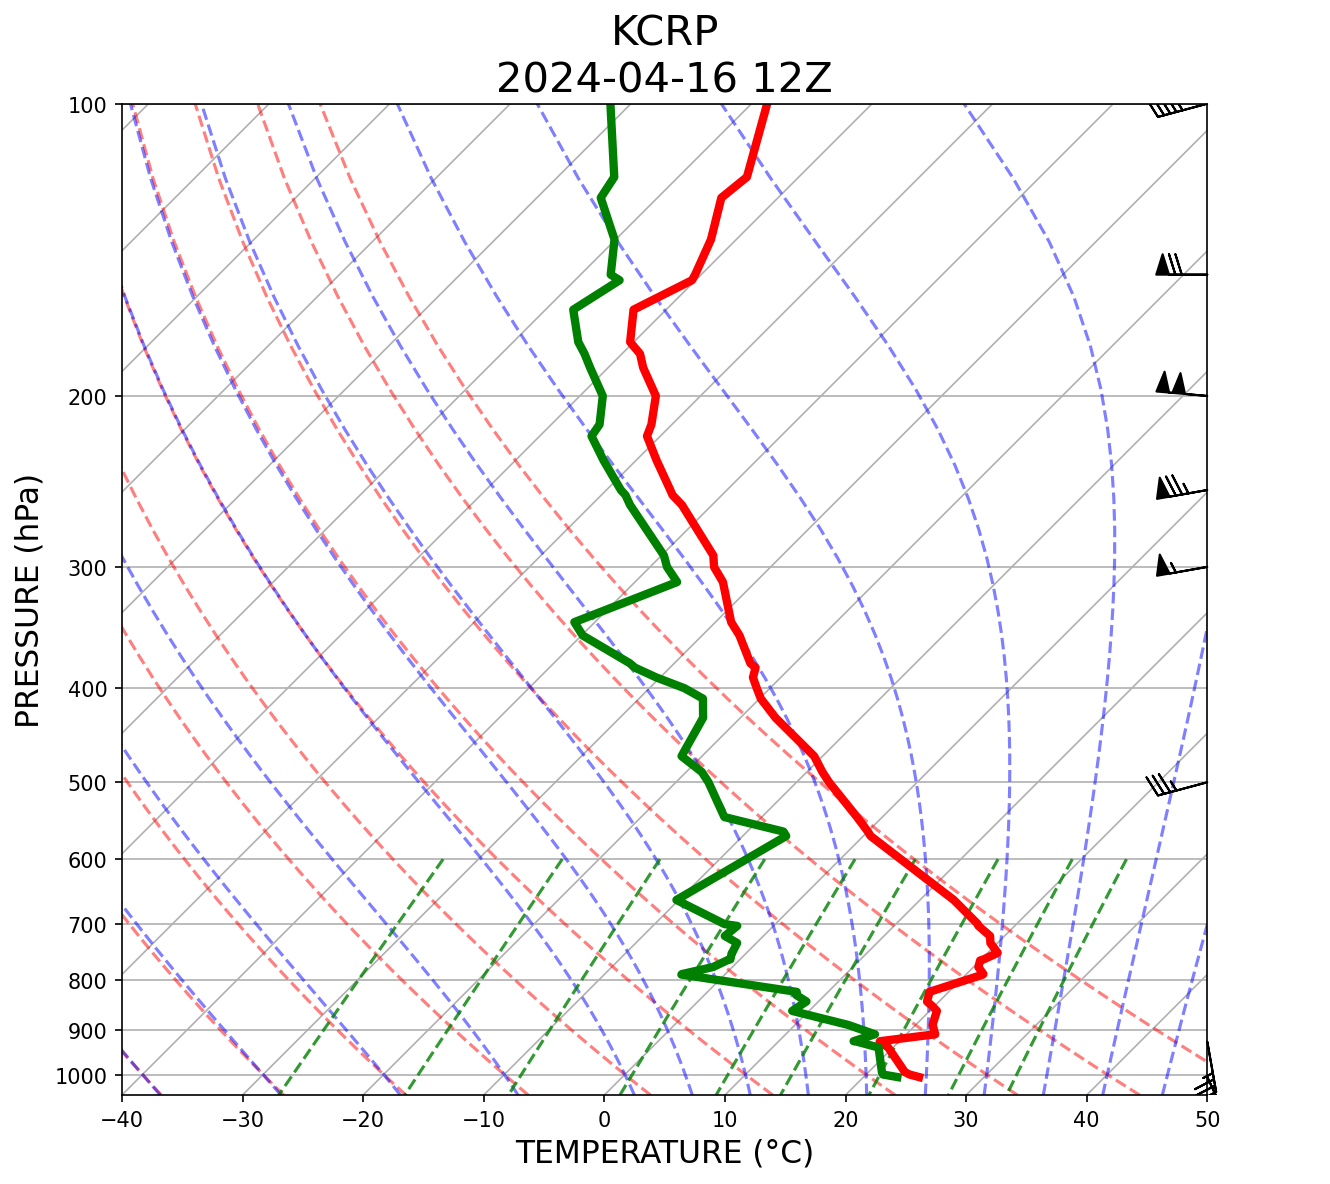

In [49]:
#create skew-t figure
fig = plt.figure(figsize=(11, 8), dpi=150,facecolor='w')
skew = SkewT(fig, rotation=45)

#plot temperature in red and dewpoint in green
skew.plot(pressure, temperature, 'r',lw=4)
skew.plot(pressure, dewpoint, 'g',lw=4)

#create axes labels
plt.xlabel('TEMPERATURE (\N{degree sign}C)',fontsize=15)
plt.ylabel('PRESSURE (hPa)',fontsize=15)

#add in typical lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#plot winds 
#only plot every other wind barb so it's not too busy
#(y_clip_radius keeps barbs from plotting outside of skew-t)
skew.plot_barbs(pressure[::2],u[::2],v[::2],y_clip_radius=0)

#add title for date and location
plt.title(f'{station}\n%04i-%02i-%02i %02iZ'%(year,month,day,hour), fontsize=20)

#save figure
fig.tight_layout()
plt.savefig(f'{station}_%04i%02i%02i_%02i.png'%(year,month,day,hour))